# Calculate the output spectrum from LTspice simulation results

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from numba import jit

In [21]:
def output_spectrum(doutfp,fin,Fs,OSR):
    #Calculate the SNR using blackman harris offset=4
    Nfft=len(doutfp)
    Ps=np.abs(np.sum(doutfp[int(Nfft*fin/Fs)-4:int(Nfft*fin/Fs)+4]))
    PN=np.abs(np.sum(doutfp[5:int(Nfft/(2*OSR))]))
    SNDR=10*np.log10(Ps/(PN-Ps))
    #atenuação blackman harris=5.88dB
    text_SNDR=f'SNDR={SNDR:.2f}'+f' dB\n Ps= {10*np.log10(abs(Ps))+5.88:.2f} dB'
    print('Ps=',Ps,'PN=',PN-Ps,text_SNDR)
    freq = np.linspace(0, 1, Nfft)
    plt.semilogx(freq[0:int(Nfft/2)],10*np.log10(abs(doutfp[0:int(Nfft/2)])))
    plt.title(f'Output spectrum SNDR={SNDR:.2f} dB')
    plt.xlabel('Frequency [f/Fs]')
    plt.ylabel('amplitude [dBr]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(1/(2*OSR), color='green') # Bandwidth
    plt.annotate(text_SNDR,
             xy = (fin/Fs, 10*np.log10(abs(doutfp[int(fin*Nfft/Fs)]))),
             xytext = (fin/Fs*10, 10*np.log10(abs(doutfp[int(fin*Nfft/Fs)]))-10),
             arrowprops = dict(facecolor = 'black', width = 0.2, headwidth = 8),
             horizontalalignment = 'center')
    #plt.show()

## Input Signal Amplitudes

### 1Vrms

In [22]:
Ain = 1.4142;           #Amplitude do sinal de entrada (1Vrms)
namefile='data/electrical_model_sim_ideal_Fs_4M_Vn_10uV_Vin_1.txt'  #Ideal
namefile='data/electrical_model_sim_real_Fs_4M_Vn_10uV_Vin_1.txt'  #Real


### Vr/2

In [7]:
Ain = 1.1200;           #Amplitude do sinal de entrada (Vr/2)
namefile='data/electrical_model_sim_ideal_Fs_4M_Vn_10uV_Vin_2.txt'  #Ideal
#namefile='data/electrical_model_sim_real_Fs_4M_Vn_10uV_Vin_2.txt'  #Real

### -20dBV

In [11]:
Ain = 0.1410;           #Amplitude do sinal de entrada (-20dBV)
namefile='data/electrical_model_sim_ideal_Fs_4M_Vn_10uV_Vin_3.txt'  #Ideal
#namefile='data/electrical_model_sim_real_Fs_4M_Vn_10uV_Vin_3.txt'  #Real

### -40dBV

In [15]:
Ain = 0.0141;           #Amplitude do sinal de entrada (-40dBV)
namefile='data/electrical_model_sim_ideal_Fs_4M_Vn_10uV_Vin_4.txt'  #Ideal
#namefile='data/electrical_model_sim_real_Fs_4M_Vn_10uV_Vin_4.txt'  #Real

## Simulation

In [23]:
#Ler ficheiro de saída da simulação que deve ter uma duração de Tsim=(40000+Nextra)*Tclk

#Nextra é o número de ciclos extra para garantir que o sinal de saída está estabilizado
#Nextra=20

BW=20e3;            #Input signal Bandwidth
Tclk=2.5e-7;        #Periodo de relógio do SDM na simulação electrica
Fs = 1/Tclk;        #Sampling grequency
Vdd=10;             #valor de Vdd na simulação electrica
OSR=Fs/(2*BW)       #Oversampling ratio


x=np.loadtxt(namefile,skiprows=1)
time=x[:,0]
vdout=x[:,1]

Pontos da sim= 5215015  numero de amostras= 40020


Text(0.5, 1.0, 'Verificar se a saida do modulador é correctamente amostrada no fim')

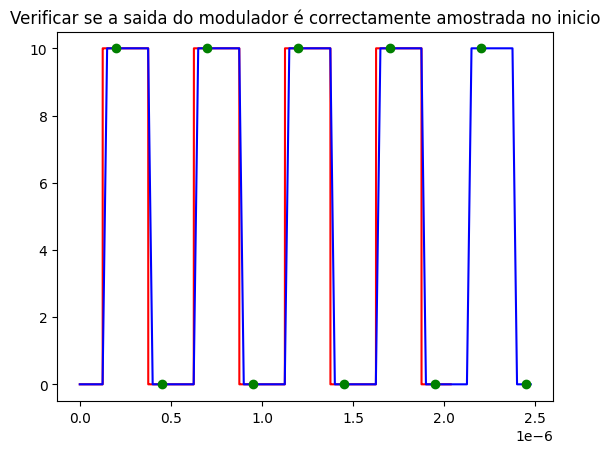

<Figure size 640x480 with 0 Axes>

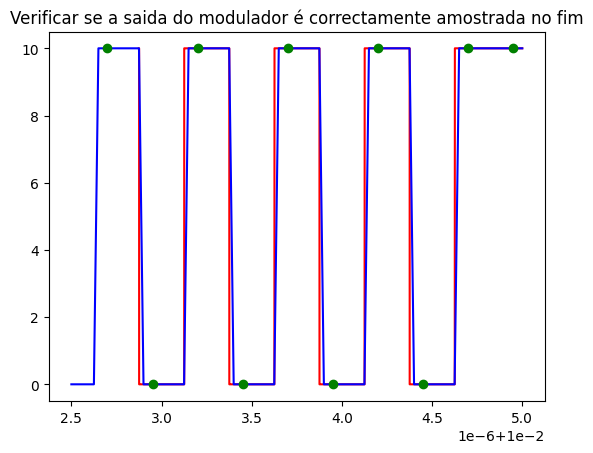

In [24]:
#Criar amostragem uniforme do resultado da simulação e amostrar dout entre +1 e -1
N=len(time)
nclk=int(time[-1]/Tclk); #numero de ciclos de relógio na simulação
np_clk=10; #numero de pontos por ciclo de relógio
dt=Tclk/np_clk; #step time para a interpolação
dts=time[-1]/N #step time médio da simulação electrica
print('Pontos da sim=',N,' numero de amostras=',nclk)

time_inter=np.arange(0,time[-1]+dt/2,dt) 
dout_inter=np.interp(time_inter,time,vdout) #interpolar os valores da simulação para terem amostragem uniforme
sample_ticks=np.arange(int(np_clk*8/10),nclk*np_clk,np_clk) #indices do vector tempo para amostrar dout a meio do relógio
dout_sampled=np.sign(dout_inter[sample_ticks]-0.5)

plot_time=10*Tclk
plt.figure()
plt.plot(time[0:int(plot_time/dts)],vdout[0:int(plot_time/dts)],'r')
plt.plot(time_inter[0:int(plot_time/(dt))],dout_inter[0:int(plot_time/(dt))],'b-')
plt.plot(time_inter[sample_ticks[0:int(plot_time/Tclk)]],(dout_sampled[0:int(plot_time/Tclk)]+1)*Vdd/2,'go')
plt.title('Verificar se a saida do modulador é correctamente amostrada no inicio')
plt.figure()
plot_time=10*Tclk
plt.figure()
plt.plot(time[int((time[-1]-plot_time)/dts):],vdout[int((time[-1]-plot_time)/dts):],'r')
plt.plot(time_inter[int((time[-1]-plot_time)/(dt)):],dout_inter[int((time[-1]-plot_time)/(dt)):],'-b')
plt.plot(time_inter[sample_ticks[int((time[-1]-plot_time)/Tclk):]],(dout_sampled[int((time[-1]-plot_time)/Tclk):]+1)*Vdd/2,'go')
plt.title('Verificar se a saida do modulador é correctamente amostrada no fim')

40000
Ps= 0.04734691493756596 PN= 2.3710943902743864e-09 SNDR=73.00 dB
 Ps= -7.37 dB
OSR= 100.0 Ps_teo= -8.32984804655302e-05


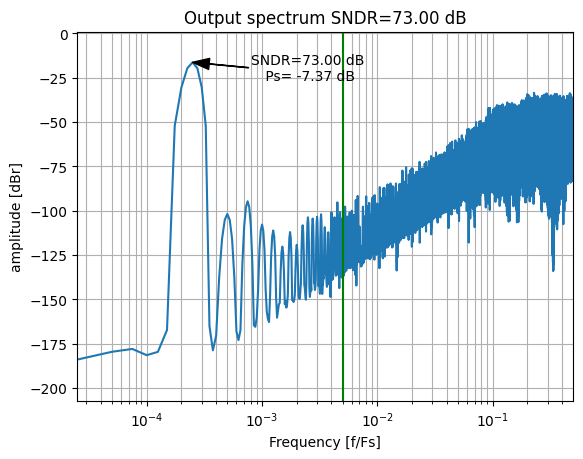

In [25]:
Nextra=20
Nfft=len(dout_sampled[Nextra:]) #Ignorar as primeiras Nextra amostras
print(Nfft)

#Blachman harris window
window = signal.windows.blackmanharris(Nfft)
#rectangular window
#window=np.ones(Nfft)
Fx=1/(Tclk*Nfft)
outf1=np.fft.fft(np.multiply(dout_sampled[Nextra:],window))
outfp1=np.abs(np.multiply(outf1,outf1.conjugate())/((Nfft)**2)*2)

output_spectrum(outfp1,1e3,Fs,OSR)
print('OSR=',OSR,'Ps_teo=',20*np.log10(Ain/np.sqrt(2)))

In [15]:
# Function to implement the third-order sinc filter
def third_order_sinc_filter(dout, M):
    
    # Integration
    int1 = np.cumsum(dout)
    int2 = np.cumsum(int1)
    int3 = np.cumsum(int2)

    # Decimation
    decim = int3[::M]

    # Differentiation
    diff1 = np.diff(np.concatenate(([0], decim)))
    diff2 = np.diff(np.concatenate(([0], diff1)))
    diff3 = np.diff(np.concatenate(([0], diff2)))

    # Gain correction
    filtered_signal = diff3 / (M ** 3)

    return filtered_signal

Ps= 0.050960741847156 PN= 1.4099450079685383e-10 SNDR=85.58 dB
 Ps= -7.05 dB
OSR= 100.0 Ps_teo= -8.32984804655302e-05


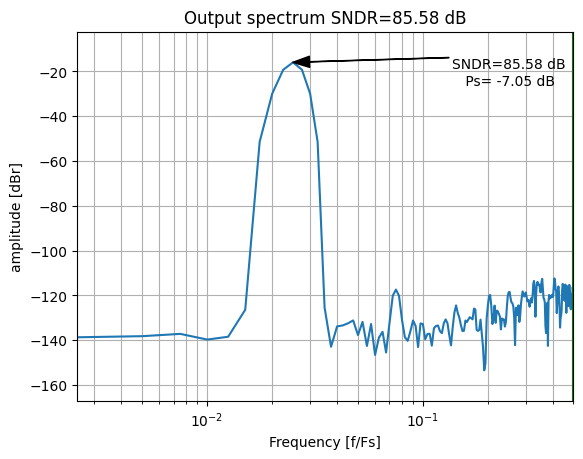

In [16]:
M = int(OSR)
filtered_signal = third_order_sinc_filter(dout_sampled[Nextra:], M)

Nfft=len(filtered_signal)
window = signal.windows.blackmanharris(Nfft)
outf2=np.fft.fft(np.multiply(filtered_signal,window))
outfp2=np.abs(np.multiply(outf2,outf2.conjugate())/((Nfft)**2)*2)

output_spectrum(outfp2,1e3,Fs/M,OSR/M)
print('OSR=',OSR,'Ps_teo=',20*np.log10(Ain/np.sqrt(2)))